In [12]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

train_dir = 'dataset_hist_structures/Stuctures_dataset'
test_dir = 'dataset_hist_structures/Dataset_test/Dataset_test_original_1478'
img_size = 224
batch_size = 32

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

train_dir = 'dataset_hist_structures/Stuctures_dataset'
test_dir = 'dataset_hist_structures/Dataset_test'
img_size = 224
batch_size = 32

def show_sample_images(data_dir):
    categories = sorted(os.listdir(data_dir))
    for category in categories:
        folder = os.path.join(data_dir, category)
        images = os.listdir(folder)[:8]
        plt.figure(figsize=(12, 3))
        for i, img_name in enumerate(images):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 8, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(category, fontsize=8)
        plt.tight_layout()
        plt.show()

def plot_class_distribution(data_dir):
    categories = sorted(os.listdir(data_dir))
    class_counts = {cat: len(os.listdir(os.path.join(data_dir, cat))) for cat in categories}
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xticks(rotation=45)
    plt.title('Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(8, 4))
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_combined_history(h1, h2, label1='Base', label2='Augmented'):
    plt.figure(figsize=(10, 5))
    plt.plot(h1.history['accuracy'], label=f'{label1} Train')
    plt.plot(h1.history['val_accuracy'], label=f'{label1} Val')
    plt.plot(h2.history['accuracy'], label=f'{label2} Train', linestyle='--')
    plt.plot(h2.history['val_accuracy'], label=f'{label2} Val', linestyle='--')
    plt.title('Training Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

print("\nTraining on base data...")
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stop])

print("\nTraining on augmented data...")
aug_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

aug_train_data = aug_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

aug_val_data = aug_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

aug_history = model.fit(aug_train_data, validation_data=aug_val_data, epochs=20, callbacks=[early_stop])

model.save('historical_structure_classifier.h5')

print("\nClass indices:")
for name, idx in train_data.class_indices.items():
    print(f"{name}: {idx}")



Found 8440 images belonging to 11 classes.
Found 2103 images belonging to 11 classes.
Found 1474 images belonging to 1 classes.

Training on base data...
Epoch 1/20
264/264 [==============================] - 289s 1s/step - loss: 0.5352 - accuracy: 0.8344 - val_loss: 0.2055 - val_accuracy: 0.9349
Epoch 2/20
264/264 [==============================] - 223s 844ms/step - loss: 0.2553 - accuracy: 0.9147 - val_loss: 0.2010 - val_accuracy: 0.9363
Epoch 3/20
264/264 [==============================] - 223s 844ms/step - loss: 0.2213 - accuracy: 0.9251 - val_loss: 0.1800 - val_accuracy: 0.9434
Epoch 4/20
264/264 [==============================] - 229s 866ms/step - loss: 0.1887 - accuracy: 0.9382 - val_loss: 0.1736 - val_accuracy: 0.9467
Epoch 5/20
264/264 [==============================] - 226s 856ms/step - loss: 0.1654 - accuracy: 0.9417 - val_loss: 0.1892 - val_accuracy: 0.9410
Epoch 6/20
264/264 [==============================] - 226s 854ms/step - loss: 0.1463 - accuracy: 0.9509 - val_loss: 0.1

UnknownError: Graph execution error:

OSError: image file is truncated (2 bytes not processed)
Traceback (most recent call last):

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    ret = func(*args)

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\keras\engine\data_adapter.py", line 902, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\keras\engine\data_adapter.py", line 1049, in generator_fn
    yield x[i]

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\keras\utils\image_utils.py", line 479, in load_img
    img = img.resize(width_height_tuple, resample)

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\PIL\Image.py", line 2301, in resize
    self.load()

  File "C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\PIL\ImageFile.py", line 387, in load
    raise OSError(msg)

OSError: image file is truncated (2 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_53264]

In [8]:
from PIL import Image, ImageFile
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Also use this here

def clean_images(root_dir):
    removed = 0
    total = 0
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            img_path = os.path.join(root, file)
            if not file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                continue
            total += 1
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except:
                print(f"Removing corrupt: {img_path}")
                try:
                    os.remove(img_path)
                    removed += 1
                except Exception as e:
                    print(f"Couldn’t delete {img_path}: {e}")
    print(f"Checked {total} files, removed {removed} corrupted ones.")

clean_images("dataset_hist_structures/Dataset_test/Dataset_test_original_1478")


Checked 1473 files, removed 0 corrupted ones.


Found 8440 images belonging to 11 classes.
Found 1473 images belonging to 10 classes.

Evaluating on test data...


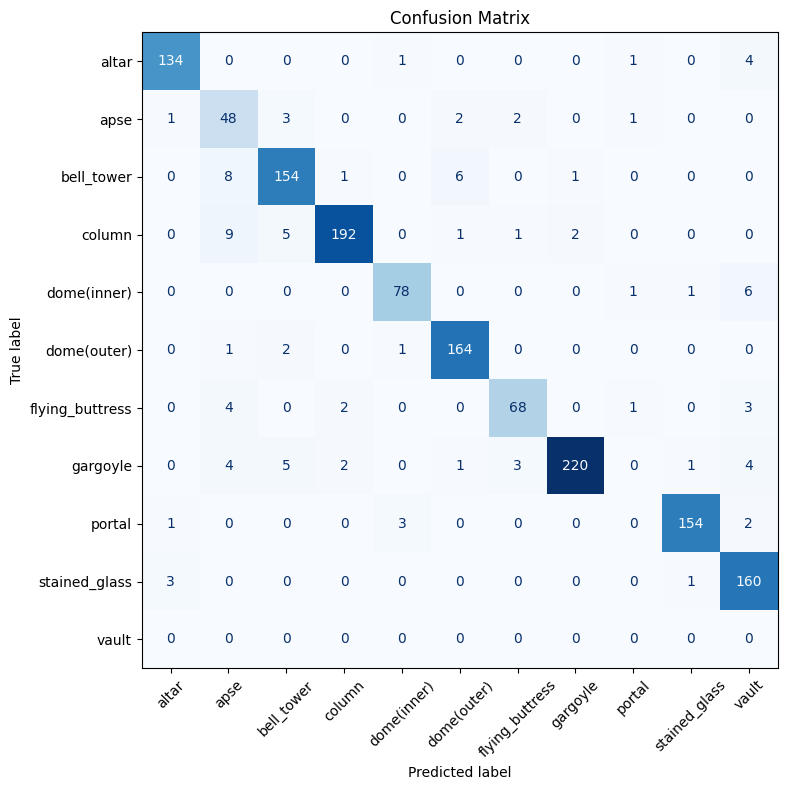


Classification Report:
                 precision    recall  f1-score   support

          altar       0.96      0.96      0.96       140
           apse       0.65      0.84      0.73        57
     bell_tower       0.91      0.91      0.91       170
         column       0.97      0.91      0.94       210
    dome(inner)       0.94      0.91      0.92        86
    dome(outer)       0.94      0.98      0.96       168
flying_buttress       0.92      0.87      0.89        78
       gargoyle       0.99      0.92      0.95       240
         portal       0.00      0.00      0.00       160
  stained_glass       0.01      0.01      0.01       164
          vault       0.00      0.00      0.00         0

       accuracy                           0.72      1473
      macro avg       0.66      0.66      0.66      1473
   weighted avg       0.73      0.72      0.73      1473


Per-Class Accuracy:
altar          : 95.71%
apse           : 84.21%
bell_tower     : 90.59%
column         : 91.43%
d

C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yuvat\AI Capstone\myenv310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


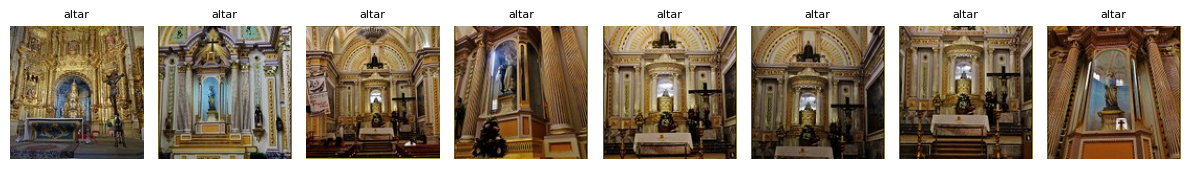

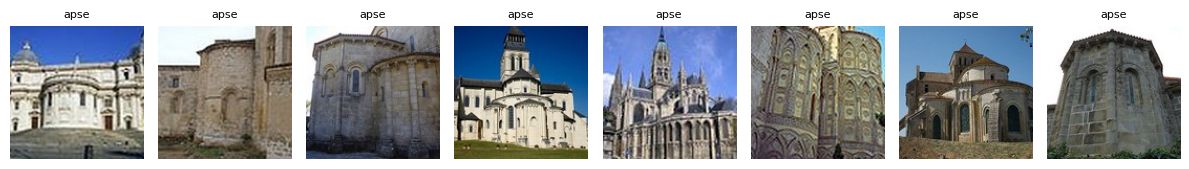

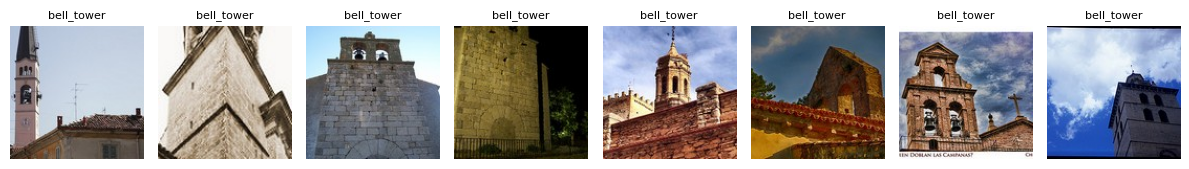

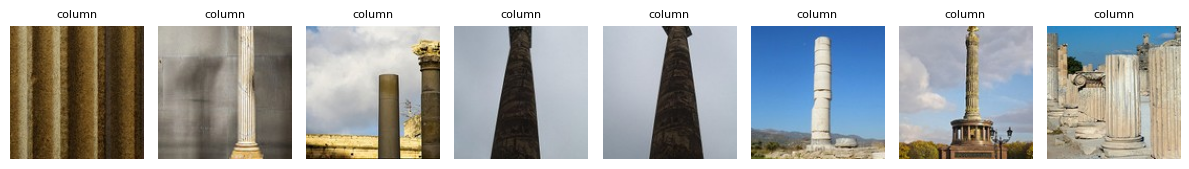

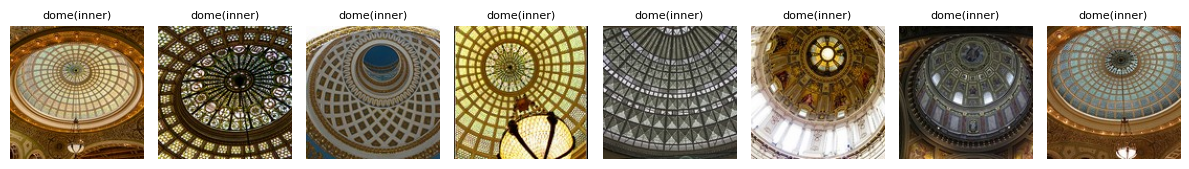

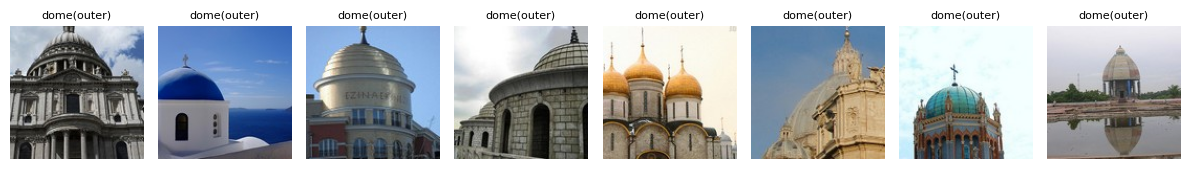

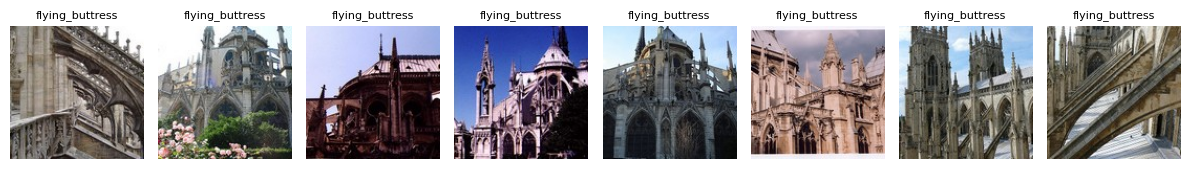

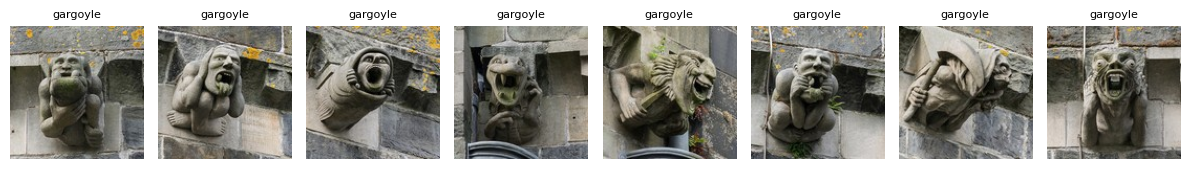

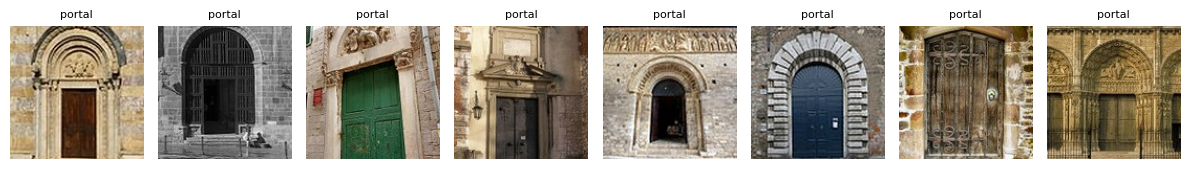

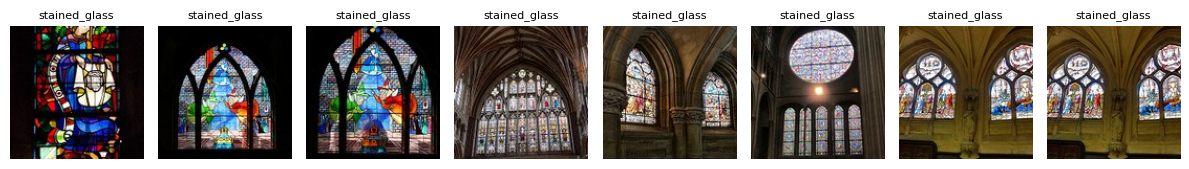

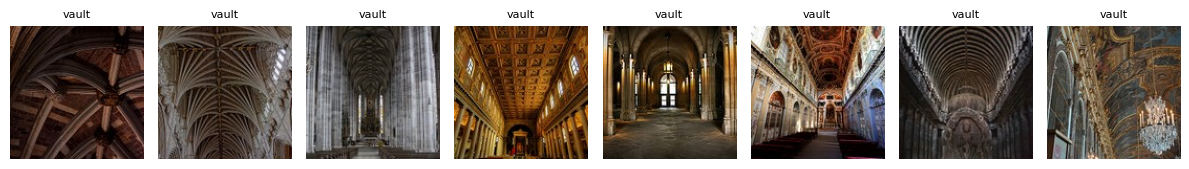

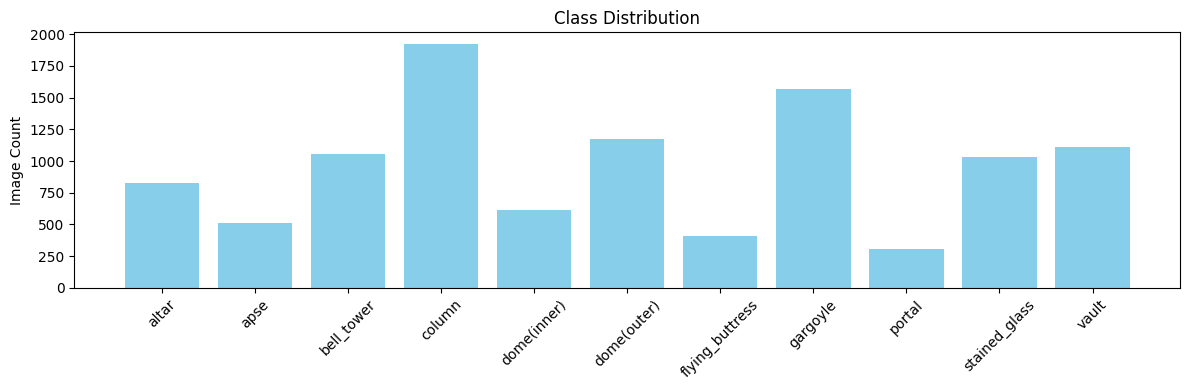

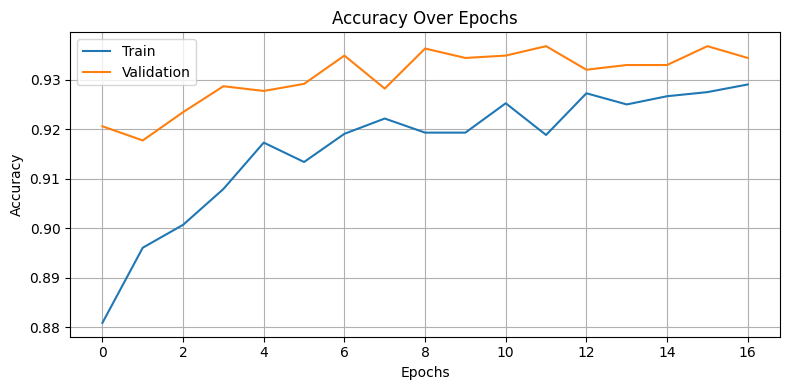

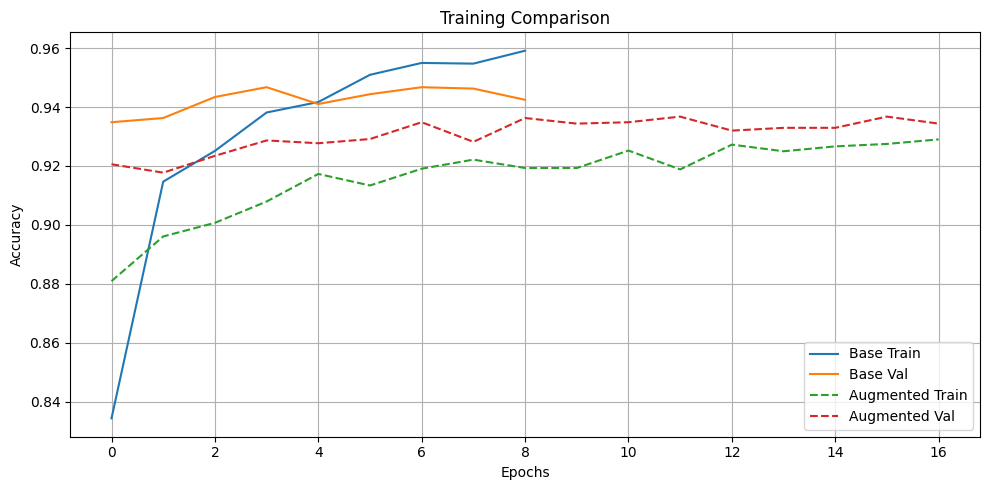


Showing 12 misclassified images


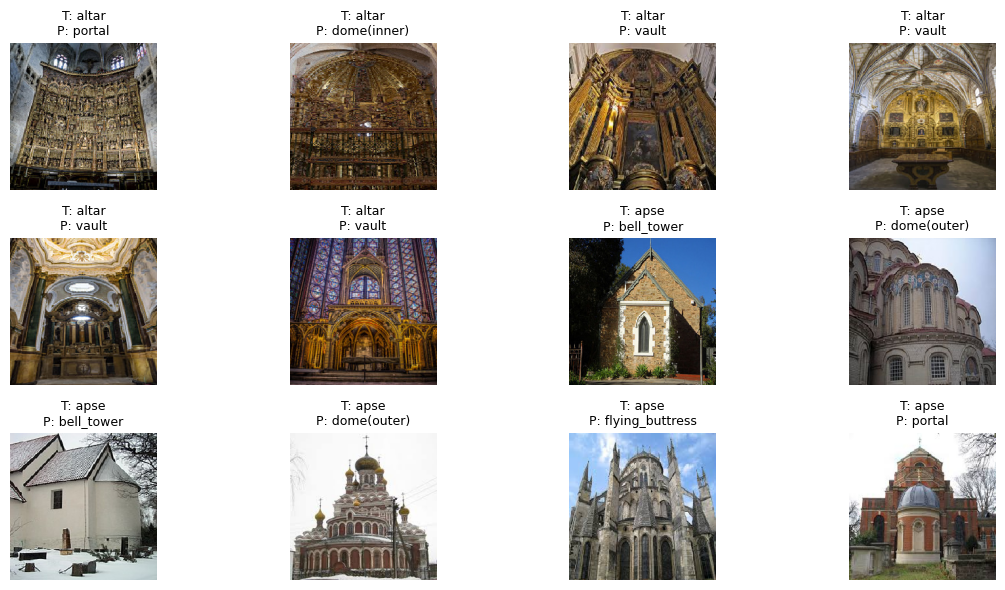

In [20]:
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt

# Setup paths
train_dir = 'dataset_hist_structures/Stuctures_dataset'
correct_test_dir = 'dataset_hist_structures/Dataset_test/Dataset_test_original_1478'

# Load training data (for label references)
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load corrected test data
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    correct_test_dir,
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

print("\nEvaluating on test data...")
preds, y_pred, y_true, valid_indices = [], [], [], []

for i in range(len(test_data)):
    try:
        x, y = test_data[i]
        pred = model.predict(x, verbose=0)
        preds.append(pred[0])
        y_pred.append(np.argmax(pred))
        y_true.append(np.argmax(y[0]))
        valid_indices.append(i)
    except Exception as e:
        print(f"Skipping corrupted image at index {i}: {e}")

y_pred = np.array(y_pred)
y_true = np.array(y_true)

full_label_map = {v: k for k, v in train_data.class_indices.items()}
unique_classes = sorted(set(y_true) | set(y_pred))
labels = [full_label_map[i] for i in unique_classes]

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_classes, target_names=labels))

def per_class_accuracy(y_true, y_pred, label_indices, label_names):
    print("\nPer-Class Accuracy:")
    for i, label in zip(label_indices, label_names):
        indices = np.where(y_true == i)[0]
        if len(indices) == 0:
            print(f"{label:15}: No true samples")
            continue
        acc = accuracy_score(y_true[indices], y_pred[indices])
        print(f"{label:15}: {acc:.2%}")

per_class_accuracy(y_true, y_pred, unique_classes, labels)

def show_misclassified_images(data, y_true, y_pred, labels, max_images=12):
    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No misclassifications found.")
        return

    print(f"\nShowing {min(len(wrong), max_images)} misclassified images")
    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(wrong[:max_images]):
        img, _ = data[valid_indices[idx]]
        true_label = labels[unique_classes.index(y_true[idx])]
        pred_label = labels[unique_classes.index(y_pred[idx])]
        plt.subplot(3, 4, i + 1)
        plt.imshow(img[0])
        plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Only keep valid directories inside train_dir (skip .DS_Store and similar)
def show_sample_images(data_dir):
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for category in categories:
        folder = os.path.join(data_dir, category)
        images = [f for f in os.listdir(folder) if not f.startswith('.')]
        if not images:
            continue
        plt.figure(figsize=(12, 3))
        for i, img_name in enumerate(images[:8]):
            img_path = os.path.join(folder, img_name)
            img = plt.imread(img_path)
            plt.subplot(1, 8, i + 1)
            plt.imshow(img)
            plt.title(category, fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def plot_class_distribution(data_dir):
    class_counts = {}
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for category in categories:
        folder = os.path.join(data_dir, category)
        count = len([f for f in os.listdir(folder) if not f.startswith('.')])
        class_counts[category] = count

    labels, values = zip(*class_counts.items())
    plt.figure(figsize=(12, 4))
    plt.bar(labels, values, color='skyblue')
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.ylabel("Image Count")
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir)
plot_class_distribution(train_dir)
plot_history(aug_history)
plot_combined_history(history, aug_history)
show_misclassified_images(test_data, y_true, y_pred, labels)
